In [2]:
import os
import sys
import time
import pickle
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate

from scipy.stats import norm, spearmanr
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

from utils import load_data
from utils import introduce_missing_data, normalization, renormalization
from utils import select_best_hyperparam
from utils import compute_sample_likelihood
from utils import compute_rmse

from knnxkde import KNNxKDE
from GAIN.gain import gain
from probabilistic_standard_methods import distribution_with_knnimputer
from probabilistic_standard_methods import distribution_with_missforest
from probabilistic_standard_methods import distribution_with_mice
from probabilistic_standard_methods import distribution_with_mean

In [3]:
NB_REPEAT = 20
LIST_MISS_RATES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

LIST_TAUS = [10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0]
LIST_NB_NEIGHBORS = [1, 2, 5, 10, 20, 50, 100]
LIST_NB_TREES = [1, 2, 3, 5, 10, 15, 20]  # computationally expensive to go higher
LIST_NB_ITERS = [100, 200, 400, 700, 1000, 2000, 4000]
LIST_LAMBDAS = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]

In [5]:
LIST_DATASETS = [
    '2d_linear',
    '2d_sine',
    '2d_ring',
    'abalone',
    'breast',  # can have too many columns at high missing rates
    'gaussians',
    'geyser',
    'japanese_vowels',  # can have too many columns at high missing rates
    'penguin',
    'planets',
    'pollen',
    'sulfur',
    'sylvine',
    'wine_red',
    'wine_white',
]

LIST_DATASETS_SORTED_DIM = [
    '2d_linear',
    '2d_sine',
    '2d_ring',
    'geyser',
    'penguin',
    'pollen',
    'planets',
    'abalone',
    'sulfur',
    'gaussians',
    'wine_red',
    'wine_white',
    'japanese_vowels',
    'sylvine',
    'breast',
]

LIST_METHODS_RMSE = [
    'knnxkde',
    'knnimputer',
    'missforest',
    'softimpute',
    'gain',
    'mice',
    'mean',
    'median',
]

LIST_METHODS_LOGLIK = [
    'knnxkde',
    'knnimputer',
    'missforest',
    'mice',
    'mean',
]

## Print results for NRMSE

In [30]:
MISS_RATE_IDX = 1  # 0: 10%, 1: 20%, 2: 30%, 3: 40%, 4: 50%, 5: 60%
rmse_mean = np.zeros((len(LIST_DATASETS), len(LIST_METHODS_RMSE)))
rmse_std = np.zeros((len(LIST_DATASETS), len(LIST_METHODS_RMSE)))

for i1 in range(len(LIST_DATASETS)):
    data_name = LIST_DATASETS[i1]
    with open(f'output/mnar/rmse/rmse_{data_name}.pkl', 'rb') as f:
        rmse_dict = pickle.load(f)
    for i2 in range(len(LIST_METHODS_RMSE)):
        meth_name = LIST_METHODS_RMSE[i2]
        mean_temp = np.mean(rmse_dict[meth_name][MISS_RATE_IDX], axis=0)
        std_temp = np.std(rmse_dict[meth_name][MISS_RATE_IDX], axis=0)
        if meth_name in ['knnxkde', 'knnimputer', 'missforest', 'softimpute', 'gain']:
            ii = np.argmin(mean_temp)  # ii = interesting index
            rmse_mean[i1, i2] = mean_temp[ii]
            rmse_std[i1, i2] = std_temp[ii]
        else:
            rmse_mean[i1, i2] = mean_temp
            rmse_std[i1, i2] = std_temp

In [31]:
rmse_mean_list = rmse_mean.tolist()
for i1 in range(len(LIST_DATASETS)):
    rmse_mean_list[i1].insert(0, LIST_DATASETS[i1])

print(tabulate(rmse_mean_list, headers=LIST_METHODS_RMSE))

                   knnxkde    knnimputer    missforest    softimpute       gain       mice       mean    median
---------------  ---------  ------------  ------------  ------------  ---------  ---------  ---------  --------
2d_linear        0.067194      0.067398      0.0856612    0.135566    0.149237   0.0666571  0.217006   0.220798
2d_sine          0.0704472     0.0728312     0.0881243    0.48385     0.264287   0.246736   0.265171   0.269608
2d_ring          0.292628      0.294118      0.393372     0.50034     0.294159   0.290926   0.290915   0.294172
abalone          0.0266414     0.0268023     0.0266891    0.0407502   0.0342737  0.026805   0.161123   0.154797
breast           0.0461419     0.0475344     0.0116946    0.00964874  0.0292364  0.0034258  0.185877   0.199845
gaussians        0.0441118     0.0433534     0.0423838    0.0867236   0.0852978  0.0596966  0.188993   0.180597
geyser           0.105537      0.106503      0.119703     0.22583     0.259172   0.140597   0.32326    0

Small quick and dirty script to generate Latex tables

In [32]:
for i1 in range(len(LIST_DATASETS_SORTED_DIM)):
    data_name = LIST_DATASETS_SORTED_DIM[i1]
    original_data = load_data(data_name)
    n, d = original_data.shape
    print('\\texttt{', end='')
    if '_' in data_name:
        ii = data_name.index('_')
        data_name_temp = data_name[:ii] + '\\' + data_name[ii:]
        print(data_name_temp, end='')
    else:
        print(data_name, end='')
    print('} & ', end='')
    print(f'{d} & ', end='')
    cur_idx = LIST_DATASETS.index(data_name)
    idx1 = np.argsort(rmse_mean[cur_idx])[0]
    idx2 = np.argsort(rmse_mean[cur_idx])[1]
    idx3 = np.argsort(rmse_mean[cur_idx])[2]
    for i2 in range(len(LIST_METHODS_RMSE)):
        if i2==idx1:
            print('\\cellcolor{green!30} ', end='')
        elif i2==idx2:
            print('\\cellcolor{yellow!30} ', end='')
        elif i2==idx3:
            print('\\cellcolor{orange!30} ', end='')
        mu = rmse_mean[cur_idx, i2]*100.0
        sigma = rmse_std[cur_idx, i2]*100.0
        print(f'{mu:.2f}', end='')
        print(' {\\scriptsize $\pm$ ', end='')
        print(f'{sigma:.2f}', end='')
        print('} ', end='')
        if i2==(len(LIST_METHODS_RMSE)-1):
            print('\\\\ ')
        else:
            print('& ', end='')
    print('\\hline')

\texttt{2d\_linear} & 2 & \cellcolor{yellow!30} 6.72 {\scriptsize $\pm$ 0.65} & \cellcolor{orange!30} 6.74 {\scriptsize $\pm$ 0.70} & 8.57 {\scriptsize $\pm$ 0.62} & 13.56 {\scriptsize $\pm$ 1.29} & 14.92 {\scriptsize $\pm$ 7.50} & \cellcolor{green!30} 6.67 {\scriptsize $\pm$ 0.58} & 21.70 {\scriptsize $\pm$ 1.70} & 22.08 {\scriptsize $\pm$ 1.85} \\ 
\hline
\texttt{2d\_sine} & 2 & \cellcolor{green!30} 7.04 {\scriptsize $\pm$ 0.68} & \cellcolor{yellow!30} 7.28 {\scriptsize $\pm$ 0.67} & \cellcolor{orange!30} 8.81 {\scriptsize $\pm$ 0.64} & 48.38 {\scriptsize $\pm$ 2.19} & 26.43 {\scriptsize $\pm$ 1.20} & 24.67 {\scriptsize $\pm$ 1.13} & 26.52 {\scriptsize $\pm$ 1.04} & 26.96 {\scriptsize $\pm$ 1.18} \\ 
\hline
\texttt{2d\_ring} & 2 & \cellcolor{orange!30} 29.26 {\scriptsize $\pm$ 1.16} & 29.41 {\scriptsize $\pm$ 1.24} & 39.34 {\scriptsize $\pm$ 2.40} & 50.03 {\scriptsize $\pm$ 1.67} & 29.42 {\scriptsize $\pm$ 2.07} & \cellcolor{yellow!30} 29.09 {\scriptsize $\pm$ 1.09} & \cellcolor{gree

Define a ranking system to aggregate results

In [14]:
def rmse_ranks(miss_mode):
    rmse_all_mean = np.zeros((6, len(LIST_DATASETS), len(LIST_METHODS_RMSE)))  # store all rmse
    
    for i1 in range(6):
        for i2 in range(len(LIST_DATASETS)):
            data_name = LIST_DATASETS[i2]
            with open(f'output/{miss_mode}/rmse/rmse_{data_name}.pkl', 'rb') as f:
                rmse_dict = pickle.load(f)
            for i3 in range(len(LIST_METHODS_RMSE)):
                meth_name = LIST_METHODS_RMSE[i3]
                mean_temp = np.mean(rmse_dict[meth_name][i1], axis=0)
                if meth_name in ['knnxkde', 'knnimputer', 'missforest', 'softimpute', 'gain']:
                    ii = np.argmin(mean_temp)  # ii = interesting index
                    rmse_all_mean[i1, i2, i3] = mean_temp[ii]
                else:
                    rmse_all_mean[i1, i2, i3] = mean_temp
    
    ranks = np.zeros((6, len(LIST_DATASETS), len(LIST_METHODS_RMSE)))
    for i1 in range(6):
        for i2 in range(len(LIST_DATASETS)):
            if np.sum(np.isnan(rmse_all_mean[i1, i2])) >= 1:
                ranks[i1, i2, :] = np.nan
            else:
                ranks[i1, i2] = np.argsort(np.argsort(rmse_all_mean[i1, i2])) + 1
    
    mean_ranks = np.round(np.nanmean(ranks, axis=1), decimals=2)
    std_ranks = np.round(np.nanstd(ranks, axis=1), decimals=2)
    return mean_ranks, std_ranks

Make super plot: all method ranks for all missing rates in all missing scenarios

In [15]:
x_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
x_jitter = [-0.014, -0.010, -0.006, -0.002, 0.002, 0.006, 0.010, 0.014]
x_tickslabels = ['10%', '20%', '30%', '40%', '50%', '60%']
y_ticks = [1, 2, 3, 4, 5, 6, 7, 8]
my_legends = ['kNNxKDE', 'kNN-Imputer', 'MissForest', 'SoftImpute', 'GAIN', 'MICE', 'Mean', 'Median']
my_colors = ['crimson', 'orange', 'mediumseagreen', 'teal', 'royalblue', 'darkorchid', 'grey', 'black']
my_labels = ['Full MCAR', 'MCAR', 'MAR', 'MNAR']

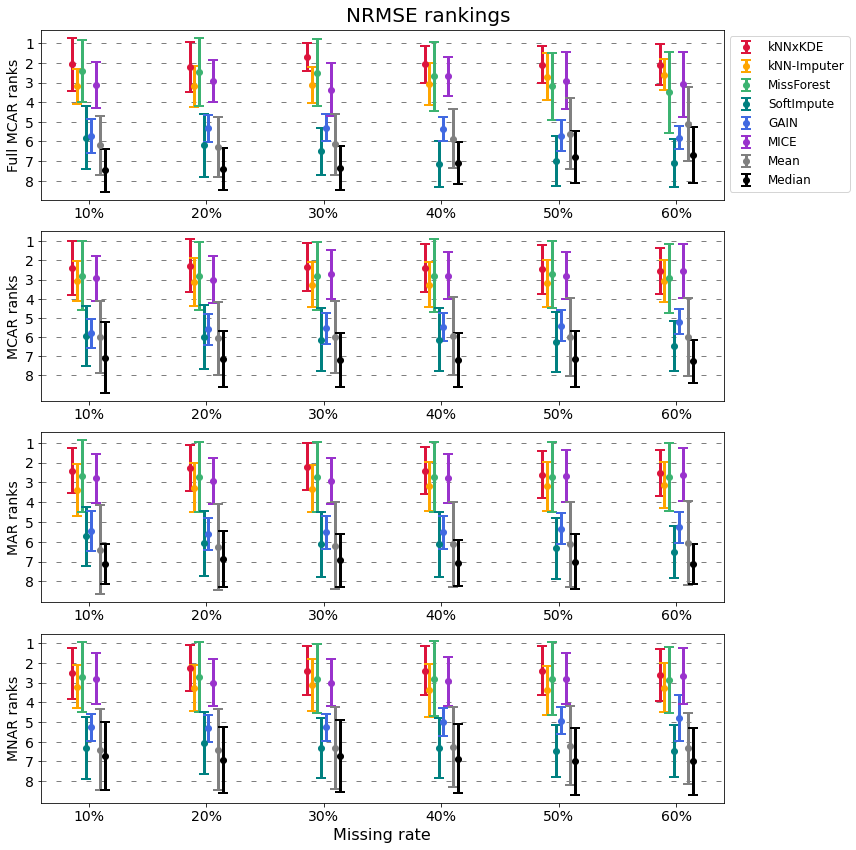

In [16]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))

for i1 in range(4):
    cur_miss_mode = ['full_mcar', 'mcar', 'mar', 'mnar'][i1]
    mean_ranks, std_ranks = rmse_ranks(miss_mode=cur_miss_mode)
    
    for i2 in range(len(LIST_METHODS_RMSE)):
        ax[i1].axhline(1+i2, ls=(0, (5, 10)), c='black', lw=1, alpha=0.5)

    for i2 in range(6):
        for i3 in range(len(LIST_METHODS_RMSE)):
            x = x_ticks[i2] + x_jitter[i3]
            y = mean_ranks[i2, i3]
            err = std_ranks[i2, i3]
            temp_c = my_colors[i3]
            if i2==0:
                ax[i1].errorbar(x, y, err, fmt='o', c=temp_c, lw=3, capsize=5, capthick=2, label=my_legends[i3])
            else:
                ax[i1].errorbar(x, y, err, fmt='o', c=temp_c, lw=3, capsize=5, capthick=2)

    ax[i1].invert_yaxis()
    ax[i1].set_xticks(x_ticks, x_tickslabels, size=14)
    ax[i1].set_yticks(y_ticks, y_ticks, size=14)
    ax[i1].set_ylabel(f'{my_labels[i1]} ranks', size=14)

fig.suptitle('NRMSE rankings', fontsize=20)
ax[0].legend(bbox_to_anchor=(1.0, 1.0), fontsize=12)
ax[3].set_xlabel('Missing rate', size=16)
plt.tight_layout()
plt.savefig(f'figures/rmse_all_ranks.pdf')

## Print results for log-likelihood

In [79]:
MISS_RATE_IDX = 1  # 0: 10%, 1: 20%, 2: 30%, 3: 40%, 4: 50%, 5: 60%
loglik_mean = np.zeros((len(LIST_DATASETS), len(LIST_METHODS_LOGLIK)))
loglik_std = np.zeros((len(LIST_DATASETS), len(LIST_METHODS_LOGLIK)))

for i1 in range(len(LIST_DATASETS)):
    data_name = LIST_DATASETS[i1]
    with open(f'output/mnar/loglik/loglik_{data_name}.pkl', 'rb') as f:
        loglik_dict = pickle.load(f)
    for i2 in range(len(LIST_METHODS_LOGLIK)):
        meth_name = LIST_METHODS_LOGLIK[i2]
        loglik_mean[i1, i2] = np.mean(loglik_dict[meth_name][MISS_RATE_IDX])
        loglik_std[i1, i2] = np.std(loglik_dict[meth_name][MISS_RATE_IDX])

In [80]:
loglik_mean_list = loglik_mean.tolist()
for i1 in range(len(LIST_DATASETS)):
    loglik_mean_list[i1].insert(0, LIST_DATASETS[i1])

print(tabulate(loglik_mean_list, headers=LIST_METHODS_LOGLIK))

                   knnxkde    knnimputer    missforest        mice        mean
---------------  ---------  ------------  ------------  ----------  ----------
2d_linear         1.20178      1.178         -8.23801    0.722355    0.0902366
2d_sine           1.06162      1.08575       -8.2492    -0.581531   -0.0908897
2d_ring           0.30883     -0.0504833     -8.53532   -0.819571   -0.186322
abalone           2.0874       2.24239       -2.36176    1.79503     0.417746
breast            1.4746       1.4261         1.87171    3.40266     0.248859
gaussians         1.64856      1.76696       -2.77628    0.938012    0.244298
geyser            0.815457     0.796624     -11.3894    -0.0667168  -0.283602
japanese_vowels   1.66024     -0.255574      -2.19905    0.299019    0.34601
penguin           0.84022      0.902331      -4.42906    0.255788   -0.0250054
planets           1.04943      1.04053       -3.80983    0.630928    0.366385
pollen            1.51741      1.5751        -3.50836    1.2

Small quick and dirty script to generate Latex tables

In [81]:
for i1 in range(len(LIST_DATASETS_SORTED_DIM)):
    data_name = LIST_DATASETS_SORTED_DIM[i1]
    original_data = load_data(data_name)
    n, d = original_data.shape
    print('\\texttt{', end='')
    if '_' in data_name:
        ii = data_name.index('_')
        data_name_temp = data_name[:ii] + '\\' + data_name[ii:]
        print(data_name_temp, end='')
    else:
        print(data_name, end='')
    print('} & ', end='')
    print(f'{d} & ', end='')
    cur_idx = LIST_DATASETS.index(data_name)
    idx1 = np.argsort(loglik_mean[cur_idx])[-1]
    idx2 = np.argsort(loglik_mean[cur_idx])[-2]
    idx3 = np.argsort(loglik_mean[cur_idx])[-3]
    for i2 in range(len(LIST_METHODS_LOGLIK)):
        if i2==idx1:
            print('\\cellcolor{green!30} ', end='')
        elif i2==idx2:
            print('\\cellcolor{yellow!30} ', end='')
        elif i2==idx3:
            print('\\cellcolor{orange!30} ', end='')
        mu = loglik_mean[cur_idx, i2]
        sigma = loglik_std[cur_idx, i2]
        print(f'{mu:.2f}', end='')
        print(' {\\scriptsize $\pm$ ', end='')
        print(f'{sigma:.3f}', end='')
        print('} ', end='')
        if i2==(len(LIST_METHODS_LOGLIK)-1):
            print('\\\\ ')
        else:
            print('& ', end='')
    print('\\hline')

\texttt{2d\_linear} & 2 & \cellcolor{green!30} 1.20 {\scriptsize $\pm$ 0.087} & \cellcolor{yellow!30} 1.18 {\scriptsize $\pm$ 0.118} & -8.24 {\scriptsize $\pm$ 0.594} & \cellcolor{orange!30} 0.72 {\scriptsize $\pm$ 0.273} & 0.09 {\scriptsize $\pm$ 0.080} \\ 
\hline
\texttt{2d\_sine} & 2 & \cellcolor{yellow!30} 1.06 {\scriptsize $\pm$ 0.126} & \cellcolor{green!30} 1.09 {\scriptsize $\pm$ 0.135} & -8.25 {\scriptsize $\pm$ 0.720} & -0.58 {\scriptsize $\pm$ 0.164} & \cellcolor{orange!30} -0.09 {\scriptsize $\pm$ 0.056} \\ 
\hline
\texttt{2d\_ring} & 2 & \cellcolor{green!30} 0.31 {\scriptsize $\pm$ 0.056} & \cellcolor{yellow!30} -0.05 {\scriptsize $\pm$ 0.054} & -8.54 {\scriptsize $\pm$ 0.425} & -0.82 {\scriptsize $\pm$ 0.218} & \cellcolor{orange!30} -0.19 {\scriptsize $\pm$ 0.048} \\ 
\hline
\texttt{geyser} & 2 & \cellcolor{green!30} 0.82 {\scriptsize $\pm$ 0.070} & \cellcolor{yellow!30} 0.80 {\scriptsize $\pm$ 0.093} & -11.39 {\scriptsize $\pm$ 0.221} & \cellcolor{orange!30} -0.07 {\scrip

Define a score system to aggregate results

In [18]:
def loglik_ranks(miss_mode):
    loglik_all_mean = np.zeros((6, len(LIST_DATASETS), len(LIST_METHODS_LOGLIK)))  # store all loglik
    
    for i1 in range(6):
        for i2 in range(len(LIST_DATASETS)):
            data_name = LIST_DATASETS[i2]
            with open(f'output/{miss_mode}/loglik/loglik_{data_name}.pkl', 'rb') as f:
                loglik_dict = pickle.load(f)
            for i3 in range(len(LIST_METHODS_LOGLIK)):
                meth_name = LIST_METHODS_LOGLIK[i3]
                mean_temp = np.mean(loglik_dict[meth_name][i1], axis=0)
                loglik_all_mean[i1, i2, i3] = mean_temp
    
    ranks = np.zeros((6, len(LIST_DATASETS), len(LIST_METHODS_LOGLIK)))
    for i1 in range(6):
        for i2 in range(len(LIST_DATASETS)):
            if np.sum(np.isnan(loglik_all_mean[i1, i2])) >= 1:
                ranks[i1, i2, :] = np.nan
            else:
                ranks[i1, i2] = np.argsort(np.argsort(-loglik_all_mean[i1, i2])) + 1  # higher = better
    
    mean_ranks = np.round(np.nanmean(ranks, axis=1), decimals=2)
    std_ranks = np.round(np.nanstd(ranks, axis=1), decimals=2)
    return mean_ranks, std_ranks

Make super plot

In [19]:
x_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
x_jitter = [-0.016, -0.008, 0.000, 0.008, 0.016]
x_tickslabels = ['10%', '20%', '30%', '40%', '50%', '60%']
y_ticks = [1, 2, 3, 4, 5]
my_legends = ['kNNxKDE', 'kNN-Imputer', 'MissForest', 'MICE', 'Mean']
my_colors = ['crimson', 'orange', 'mediumseagreen', 'darkorchid', 'grey']
my_labels = ['Full MCAR', 'MCAR', 'MAR', 'MNAR']

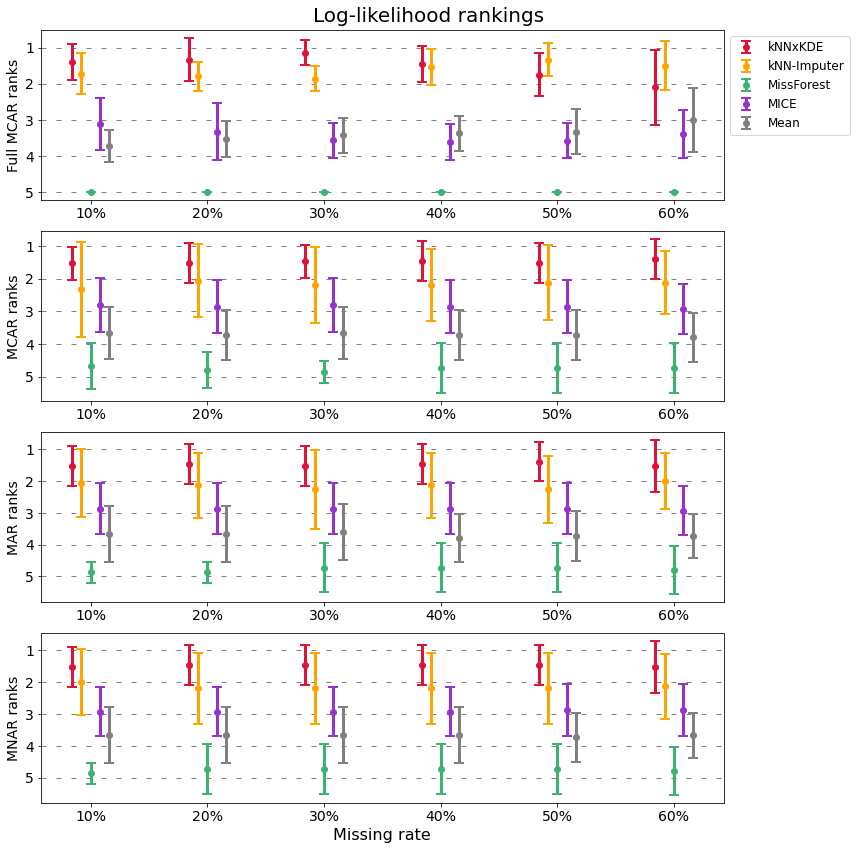

In [20]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))

for i1 in range(4):
    cur_miss_mode = ['full_mcar', 'mcar', 'mar', 'mnar'][i1]
    mean_ranks, std_ranks = loglik_ranks(miss_mode=cur_miss_mode)
    
    for i2 in range(len(LIST_METHODS_LOGLIK)):
        ax[i1].axhline(1+i2, ls=(0, (5, 10)), c='black', lw=1, alpha=0.5)

    for i2 in range(6):
        for i3 in range(len(LIST_METHODS_LOGLIK)):
            x = x_ticks[i2] + x_jitter[i3]
            y = mean_ranks[i2, i3]
            err = std_ranks[i2, i3]
            temp_c = my_colors[i3]
            if i2==0:
                ax[i1].errorbar(x, y, err, fmt='o', c=temp_c, lw=3, capsize=5, capthick=2, label=my_legends[i3])
            else:
                ax[i1].errorbar(x, y, err, fmt='o', c=temp_c, lw=3, capsize=5, capthick=2)

    ax[i1].invert_yaxis()
    ax[i1].set_xticks(x_ticks, x_tickslabels, size=14)
    ax[i1].set_yticks(y_ticks, y_ticks, size=14)
    ax[i1].set_ylabel(f'{my_labels[i1]} ranks', size=14)

fig.suptitle('Log-likelihood rankings', fontsize=20)
ax[0].legend(bbox_to_anchor=(1.0, 1.0), fontsize=12)
ax[3].set_xlabel('Missing rate', size=16)
plt.tight_layout()
plt.savefig(f'figures/loglik_all_ranks.pdf')